In [1]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from tqdm import tqdm

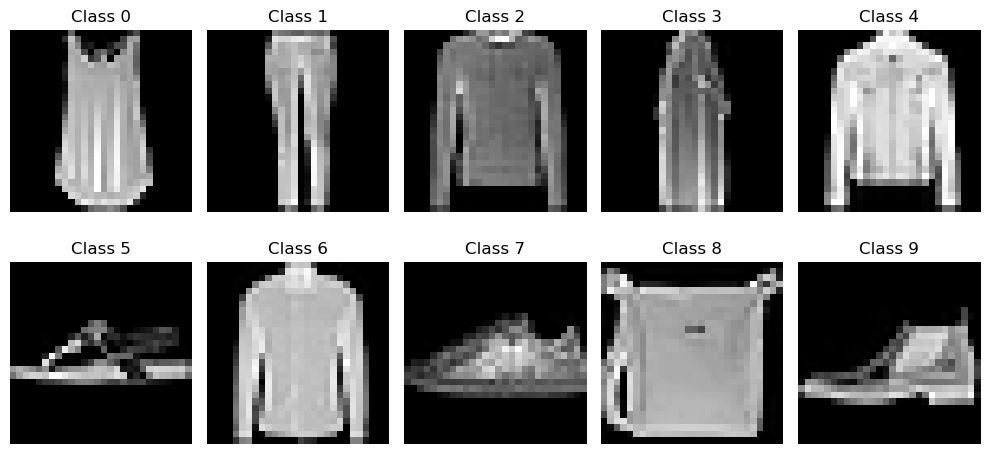

In [3]:
indices = [np.random.choice(np.where(y_train == c)[0]) for c in range(10)]
# print(indices)

m = x_train.shape[0]

fig, axes = plt.subplots(2, 5, figsize=(10, 5)) 
axes = axes.ravel()

for i, idx in enumerate(indices):
    axes[i].imshow(x_train[idx], cmap="gray")  # Display image
    axes[i].set_title(f"Class {i}")  # Set title
    axes[i].axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [6]:
class neural_network:
    def __init__(self, input_size=784, num_layers=3, output_size=10, hidden_layer_size=[128,64,32], eta=0.001):
        self.input_size = input_size
        self.num_layers = num_layers # L-1
        self.output_size = output_size
        self.eta = eta # learning rate
        self.hidden_layer_size = hidden_layer_size
        self.layer_size = np.hstack(([input_size],hidden_layer_size,[output_size]))
        self.weights = {f"W{i+1}": np.random.randn(self.layer_size[i+1], self.layer_size[i]) * 0.01 for i in range(self.num_layers + 1)}
        self.biases = {f"b{i+1}": np.random.randn(self.layer_size[i+1],1) * 0.01 for i in range(self.num_layers + 1)}
        self.a = {f"a{i+1}": np.zeros((self.layer_size[i+1],1)) for i in range(self.num_layers + 1)}        
        self.h = {f"h{i+1}": np.zeros((self.layer_size[i+1],1)) for i in range(self.num_layers + 1)}
        self.gradients = {f"a{i+1}": np.zeros(self.a[f"a{i+1}"].shape) for i in range(self.num_layers + 1)}
        self.gradients.update({f"h{i+1}": np.zeros(self.h[f"h{i+1}"].shape) for i in range(self.num_layers + 1)})
        self.gradients.update({f"W{i+1}": np.zeros(self.weights[f"W{i+1}"].shape) for i in range(self.num_layers + 1)})
        self.gradients.update({f"b{i+1}": np.zeros(self.biases[f"b{i+1}"].shape) for i in range(self.num_layers + 1)})

    def activation(self, a):
        return 1/(1+np.exp(-a))

    def activation_derivative(self, a):
        return self.activation(a)*(1-self.activation(a)) # works only for sigmoid

    def output(self, a):
        exp_shifted = np.exp(a - np.max(a))  # Prevent overflow
        return exp_shifted / np.sum(exp_shifted, axis=0, keepdims=True)
        # return np.exp(a)/(np.sum(np.exp(a))+1e-9)

    def forward_propagation(self, input):
        self.a["a1"] = np.matmul(self.weights["W1"], input) + self.biases["b1"]
        for i in range(1,self.num_layers + 1):
            self.h[f"h{i}"] = self.activation(self.a[f"a{i}"])
            self.a[f"a{i+1}"] = np.matmul(self.weights[f"W{i+1}"], self.h[f"h{i}"]) + self.biases[f"b{i+1}"]
        self.h[f"h{self.num_layers+1}"] = self.output(self.a[f"a{self.num_layers+1}"])
        return self.h[f"h{self.num_layers+1}"]

    def one_hot_vector(self, output):
        e = np.zeros((self.output_size,1))
        e[output] = 1
        return e
    
    def backward_propagation(self, input, output):
        self.gradients[f"a{self.num_layers+1}"] = - (self.one_hot_vector(output)-self.h[f"h{self.num_layers+1}"])
        for k in range(self.num_layers+1,1,-1):
            self.gradients[f"W{k}"] = np.matmul(self.gradients[f"a{k}"], np.transpose(self.h[f"h{k-1}"]))
            self.gradients[f"b{k}"] = self.gradients[f"a{k}"]
            self.gradients[f"h{k-1}"] = np.matmul(np.transpose(self.weights[f"W{k}"]), self.gradients[f"a{k}"])
            self.gradients[f"a{k-1}"] = np.multiply(self.gradients[f"h{k-1}"], self.activation_derivative(self.a[f"a{k-1}"]))
        self.gradients["W1"] = np.matmul(self.gradients[f"a{1}"], np.transpose(input))
        self.gradients["b1"] = self.gradients["a1"]

    def loss(self, x_train, y_train):
        loss = 0
        for i in range(x_train.shape[0]):
            prediction = self.forward_propagation(x_train[i].reshape(self.input_size,1))
            epsilon = 1e-9
            prob = np.clip(prediction[y_train[i], 0], epsilon, 1 - epsilon)
            loss += -np.log(prob)
        return loss
    
    def gradient_descent(self, x_train, y_train):
        max_epochs = 1000
        for epoch in tqdm(range(1,max_epochs+1), desc="Training Progress"): 
            loss = self.loss(x_train, y_train)/x_train.shape[0]
            print(f"Epoch {epoch}/{max_epochs} - Loss: {loss:.4f}")
            d_theta = {f"a{i+1}": np.zeros(self.a[f"a{i+1}"].shape) for i in range(self.num_layers + 1)}
            d_theta.update({f"h{i+1}": np.zeros(self.h[f"h{i+1}"].shape) for i in range(self.num_layers + 1)})
            d_theta.update({f"W{i+1}": np.zeros(self.weights[f"W{i+1}"].shape) for i in range(self.num_layers + 1)})
            d_theta.update({f"b{i+1}": np.zeros(self.biases[f"b{i+1}"].shape) for i in range(self.num_layers + 1)})
            for i in range(x_train.shape[0]):
                input = x_train[i].reshape(self.input_size,1)
                output = y_train[i]
                self.forward_propagation(input)
                self.backward_propagation(input, output)
                d_theta = {key: value + self.gradients[key] for key, value in d_theta.items()}
            print(f"Gradient Norm: {np.linalg.norm(d_theta['W1'])}")
            self.weights = {key: value - self.eta*d_theta[key] for key, value in self.weights.items()}
            self.biases = {key: value - self.eta*d_theta[key] for key, value in self.biases.items()}

nn = neural_network(hidden_layer_size=[32,32,32])

In [ ]:
nn.gradient_descent(x_train, y_train)

Training Progress:   0%|                                                | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000 - Loss: 2.3028


Training Progress:   0%|                                      | 1/1000 [00:10<2:59:45, 10.80s/it]

Gradient Norm: 6.152430866094527
Epoch 2/1000 - Loss: 2.9144


Training Progress:   0%|                                      | 2/1000 [00:19<2:43:01,  9.80s/it]

Gradient Norm: 247.84543510736188
Epoch 3/1000 - Loss: 6.3196


Training Progress:   0%|                                      | 3/1000 [00:28<2:34:07,  9.28s/it]

Gradient Norm: 391.0756387507481
Epoch 4/1000 - Loss: 7.8560


Training Progress:   0%|▏                                     | 4/1000 [00:37<2:28:46,  8.96s/it]

Gradient Norm: 9.578872522650922
Epoch 5/1000 - Loss: 8.7272


Training Progress:   0%|▏                                     | 5/1000 [00:45<2:27:08,  8.87s/it]

Gradient Norm: 2.4441996846743654
Epoch 6/1000 - Loss: 8.4055


Training Progress:   1%|▏                                     | 6/1000 [00:54<2:25:06,  8.76s/it]

Gradient Norm: 1.8592205835514153
Epoch 7/1000 - Loss: 8.3740


Training Progress:   1%|▎                                     | 7/1000 [01:02<2:24:27,  8.73s/it]

Gradient Norm: 16.414363775339545
Epoch 8/1000 - Loss: 8.5164


Training Progress:   1%|▎                                     | 8/1000 [01:11<2:24:04,  8.71s/it]

Gradient Norm: 3.2256578777589535
Epoch 9/1000 - Loss: 9.4946


Training Progress:   1%|▎                                     | 9/1000 [01:20<2:23:10,  8.67s/it]

Gradient Norm: 5.247731236906224
Epoch 10/1000 - Loss: 9.9159


Training Progress:   1%|▎                                    | 10/1000 [01:28<2:21:51,  8.60s/it]

Gradient Norm: 1.9958683690719992
Epoch 11/1000 - Loss: 10.6651


Training Progress:   1%|▍                                    | 11/1000 [01:37<2:23:39,  8.72s/it]

Gradient Norm: 5.584490103228047
Epoch 12/1000 - Loss: 12.2463


Training Progress:   1%|▍                                    | 12/1000 [01:48<2:35:20,  9.43s/it]

Gradient Norm: 2.277511939747718
Epoch 13/1000 - Loss: 12.6345


Training Progress:   1%|▍                                    | 13/1000 [01:59<2:44:04,  9.97s/it]

Gradient Norm: 10.868668307440256
Epoch 14/1000 - Loss: 11.5402


Training Progress:   1%|▌                                    | 14/1000 [02:09<2:43:55,  9.98s/it]

Gradient Norm: 14.41826946673978
Epoch 15/1000 - Loss: 9.1786


Training Progress:   2%|▌                                    | 15/1000 [02:18<2:37:54,  9.62s/it]

Gradient Norm: 2.2750742425303017
Epoch 16/1000 - Loss: 10.1815


Training Progress:   2%|▌                                    | 16/1000 [02:28<2:38:20,  9.66s/it]

Gradient Norm: 16.478808379136492
Epoch 17/1000 - Loss: 10.4299


Training Progress:   2%|▋                                    | 17/1000 [02:36<2:31:50,  9.27s/it]

Gradient Norm: 2.980279856704146
Epoch 18/1000 - Loss: 12.6204


Training Progress:   2%|▋                                    | 18/1000 [02:45<2:27:46,  9.03s/it]

Gradient Norm: 45.96228150423413
Epoch 19/1000 - Loss: 11.6260


Training Progress:   2%|▋                                    | 19/1000 [02:53<2:24:11,  8.82s/it]

Gradient Norm: 23.410321687567933
Epoch 20/1000 - Loss: 10.7360


Training Progress:   2%|▋                                    | 20/1000 [03:01<2:21:43,  8.68s/it]

Gradient Norm: 3.5855066700644986
Epoch 21/1000 - Loss: 12.9569


Training Progress:   2%|▊                                    | 21/1000 [03:10<2:19:35,  8.56s/it]

Gradient Norm: 2.8582692310377658
Epoch 22/1000 - Loss: 15.0230


Training Progress:   2%|▊                                    | 22/1000 [03:18<2:17:55,  8.46s/it]

Gradient Norm: 7.234308816984663
Epoch 23/1000 - Loss: 14.4524


Training Progress:   2%|▊                                    | 23/1000 [03:26<2:17:12,  8.43s/it]

Gradient Norm: 16.258475787786747
Epoch 24/1000 - Loss: 11.9185


Training Progress:   2%|▉                                    | 24/1000 [03:35<2:16:42,  8.40s/it]

Gradient Norm: 10.004341118820717
Epoch 25/1000 - Loss: 13.0940


Training Progress:   2%|▉                                    | 25/1000 [03:43<2:16:25,  8.40s/it]

Gradient Norm: 3.5215612953849793
Epoch 26/1000 - Loss: 12.3609


Training Progress:   3%|▉                                    | 26/1000 [03:51<2:16:12,  8.39s/it]

Gradient Norm: 23.06372363109008
Epoch 27/1000 - Loss: 11.8682


Training Progress:   3%|▉                                    | 27/1000 [04:00<2:16:29,  8.42s/it]

Gradient Norm: 19.093079437106677
Epoch 28/1000 - Loss: 14.0898


Training Progress:   3%|█                                    | 28/1000 [04:08<2:15:21,  8.36s/it]

Gradient Norm: 28.0158455637967
Epoch 29/1000 - Loss: 14.0628


Training Progress:   3%|█                                    | 29/1000 [04:17<2:15:26,  8.37s/it]

Gradient Norm: 8.021794957379198
Epoch 30/1000 - Loss: 13.9971


Training Progress:   3%|█                                    | 30/1000 [04:25<2:15:07,  8.36s/it]

Gradient Norm: 3.1874754823418368
Epoch 31/1000 - Loss: 13.5094


Training Progress:   3%|█▏                                   | 31/1000 [04:33<2:14:59,  8.36s/it]

Gradient Norm: 45.18770120929475
Epoch 32/1000 - Loss: 12.8192


Training Progress:   3%|█▏                                   | 32/1000 [04:41<2:14:16,  8.32s/it]

Gradient Norm: 35.80547449013454
Epoch 33/1000 - Loss: 14.3650


Training Progress:   3%|█▏                                   | 33/1000 [04:50<2:14:43,  8.36s/it]

Gradient Norm: 12.267134065936602
Epoch 34/1000 - Loss: 13.1442


Training Progress:   3%|█▎                                   | 34/1000 [04:58<2:14:21,  8.35s/it]

Gradient Norm: 2.7839558859695703
Epoch 35/1000 - Loss: 14.1409


Training Progress:   4%|█▎                                   | 35/1000 [05:06<2:13:49,  8.32s/it]

Gradient Norm: 8.913917058494178
Epoch 36/1000 - Loss: 11.6931


Training Progress:   4%|█▎                                   | 36/1000 [05:15<2:13:20,  8.30s/it]

Gradient Norm: 2.1615934898313665
Epoch 37/1000 - Loss: 11.3488


Training Progress:   4%|█▎                                   | 37/1000 [05:23<2:12:56,  8.28s/it]

Gradient Norm: 5.7434128979172465
Epoch 38/1000 - Loss: 13.5226


Training Progress:   4%|█▍                                   | 38/1000 [05:31<2:12:48,  8.28s/it]

Gradient Norm: 1.6161154077846092
Epoch 39/1000 - Loss: 12.5335


Training Progress:   4%|█▍                                   | 39/1000 [05:40<2:12:42,  8.29s/it]

Gradient Norm: 2.6060703877246265
Epoch 40/1000 - Loss: 10.1117


Training Progress:   4%|█▍                                   | 40/1000 [05:48<2:13:33,  8.35s/it]

Gradient Norm: 26.585956469886348
Epoch 41/1000 - Loss: 10.2250


Training Progress:   4%|█▌                                   | 41/1000 [05:56<2:13:42,  8.37s/it]

Gradient Norm: 4.448488434608902
Epoch 42/1000 - Loss: 11.3565


Training Progress:   4%|█▌                                   | 42/1000 [06:05<2:13:07,  8.34s/it]

Gradient Norm: 10.495802315320907
Epoch 43/1000 - Loss: 11.7187


Training Progress:   4%|█▌                                   | 43/1000 [06:13<2:12:50,  8.33s/it]

Gradient Norm: 6.04353364256959
Epoch 44/1000 - Loss: 12.1069


Training Progress:   4%|█▋                                   | 44/1000 [06:21<2:12:39,  8.33s/it]

Gradient Norm: 2.5969403741138612
Epoch 45/1000 - Loss: 13.0166


Training Progress:   4%|█▋                                   | 45/1000 [06:30<2:12:28,  8.32s/it]

Gradient Norm: 1.3987586709407287
Epoch 46/1000 - Loss: 12.2998


Training Progress:   5%|█▋                                   | 46/1000 [06:38<2:12:09,  8.31s/it]

Gradient Norm: 15.713384632785187
Epoch 47/1000 - Loss: 12.4472


Training Progress:   5%|█▋                                   | 47/1000 [06:46<2:11:37,  8.29s/it]

Gradient Norm: 2.771208108628809
Epoch 48/1000 - Loss: 14.1091


Training Progress:   5%|█▊                                   | 48/1000 [06:54<2:11:33,  8.29s/it]

Gradient Norm: 4.996446639518052
Epoch 49/1000 - Loss: 11.0264


Training Progress:   5%|█▊                                   | 49/1000 [07:03<2:11:20,  8.29s/it]

Gradient Norm: 25.339886879946256
Epoch 50/1000 - Loss: 9.8887


Training Progress:   5%|█▊                                   | 50/1000 [07:11<2:11:15,  8.29s/it]

Gradient Norm: 29.946013604780216
Epoch 51/1000 - Loss: 11.4863


Training Progress:   5%|█▉                                   | 51/1000 [07:19<2:11:06,  8.29s/it]

Gradient Norm: 3.161764887368901
Epoch 52/1000 - Loss: 11.7149


Training Progress:   5%|█▉                                   | 52/1000 [07:28<2:10:50,  8.28s/it]

Gradient Norm: 5.254925997597464
Epoch 53/1000 - Loss: 12.1198


Training Progress:   5%|█▉                                   | 53/1000 [07:36<2:10:26,  8.26s/it]

Gradient Norm: 5.958109225626786
Epoch 54/1000 - Loss: 11.1784


Training Progress:   5%|█▉                                   | 54/1000 [07:44<2:10:53,  8.30s/it]

Gradient Norm: 2.187921818903341
Epoch 55/1000 - Loss: 10.7930


Training Progress:   6%|██                                   | 55/1000 [07:52<2:10:42,  8.30s/it]

Gradient Norm: 11.160225986427525
Epoch 56/1000 - Loss: 11.2373


Training Progress:   6%|██                                   | 56/1000 [08:02<2:14:08,  8.53s/it]

Gradient Norm: 6.791151500987282
Epoch 57/1000 - Loss: 10.4396


Training Progress:   6%|██                                   | 57/1000 [08:10<2:12:59,  8.46s/it]